## Import & Load

In [ ]:
!pip install scikeras

In [3]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
from google.colab import files
files.upload()


In [5]:
dataset = pd.read_csv('BTC-USD.csv')

In [6]:
dataset.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
361,2024-01-09,46987.640625,47893.699219,45244.714844,46139.730469,46139.730469,39821290992
362,2024-01-10,46121.539063,47647.222656,44483.152344,46627.777344,46627.777344,50114613298
363,2024-01-11,46656.074219,48969.371094,45678.644531,46368.585938,46368.585938,45833734549
364,2024-01-12,46354.792969,46498.136719,41903.769531,42853.167969,42853.167969,43332698900
365,2024-01-13,42799.445313,43234.660156,42464.460938,42820.339844,42820.339844,30452895744


## Data Preparation

In [7]:
# Create short simple moving average over the short window
dataset['short_mavg'] = dataset['Close'].rolling(window=10, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
dataset['long_mavg'] = dataset['Close'].rolling(window=60, min_periods=1, center=False).mean()

# Create signals
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

In [8]:
dataset.sample(5)

,Date,Open,High,Low,Close,Adj Close,Volume,short_mavg,long_mavg,signal
337,2023-12-16,41937.742188,42664.945313,41723.113281,42240.117188,42240.117188,14386729590,42774.359375,37126.297331,1.0
246,2023-09-16,26606.199219,26754.769531,26473.890625,26568.281250,26568.281250,7402031417,26081.472461,27714.310091,0.0
210,2023-08-11,29424.902344,29517.773438,29253.517578,29397.714844,29397.714844,10195168197,29282.358399,29481.428353,0.0
260,2023-09-30,26911.689453,27091.794922,26888.968750,26967.916016,26967.916016,5331172801,26575.304883,27049.082292,0.0
155,2023-06-17,26328.679688,26769.394531,26174.492188,26510.675781,26510.675781,11090276850,26014.043750,27359.484017,0.0


## Feature Engineering

In [9]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)

#calculation of rate of change
def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))
    return ROC
dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)

#Calculation of price momentum
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM
dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)

#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)

#calculation of stochastic osillator.

def STOK(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA

In [10]:
dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['MA21'] = MA(dataset, 10)
dataset['MA63'] = MA(dataset, 30)
dataset['MA252'] = MA(dataset, 200)

In [11]:
dataset.sample(5)

,Date,Open,High,Low,Close,Adj Close,Volume,short_mavg,long_mavg,signal,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
4,2023-01-17,21175.833984,21438.660156,20978.533203,21161.519531,21161.519531,24999983362,20819.564844,20819.564844,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,2023-01-27,23030.716797,23417.720703,22654.593750,23078.728516,23078.728516,25383335641,22475.043359,21923.217188,1.0,...,NaN,79.771733,79.700254,NaN,NaN,NaN,NaN,22475.043359,NaN,NaN
155,2023-06-17,26328.679688,26769.394531,26174.492188,26510.675781,26510.675781,11090276850,26014.043750,27359.484017,0.0,...,NaN,85.660584,58.921826,47.140814,36.892911,NaN,NaN,26014.043750,26658.394271,NaN
194,2023-07-26,29225.759766,29675.552734,29113.912109,29354.972656,29354.972656,13497554655,29723.275586,28817.313119,1.0,...,NaN,30.003287,21.880052,14.605746,11.068533,NaN,NaN,29723.275586,30236.210287,NaN
132,2023-05-25,26329.460938,26591.519531,25890.593750,26476.207031,26476.207031,13851122697,26892.923242,28218.884701,0.0,...,NaN,37.159769,39.273554,14.518292,19.441542,NaN,NaN,26892.923242,27796.379427,NaN


In [12]:
dataset = dataset.fillna(0)

In [13]:
dataset.sample(5)

,Date,Open,High,Low,Close,Adj Close,Volume,short_mavg,long_mavg,signal,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
343,2023-12-22,43868.988281,44367.957031,43441.968750,43997.902344,43997.902344,21028503216,42786.262500,38427.103906,1.0,...,59.406492,90.357382,88.026791,91.105231,90.063210,96.445645,95.651335,42786.262500,41147.153386,31185.321621
307,2023-11-16,37879.980469,37934.625000,35545.472656,36154.769531,36154.769531,26007385366,36537.385156,30748.896647,1.0,...,57.381434,47.058098,57.977412,81.511683,86.176889,86.253322,89.139902,36537.385156,34321.641016,28839.300283
190,2023-07-22,29908.697266,29991.615234,29664.121094,29771.802734,29771.802734,7873300598,30174.399414,28626.560645,1.0,...,0.000000,9.537937,11.857810,9.537937,22.621226,0.000000,0.000000,30174.399414,30374.601563,0.000000
236,2023-09-06,25783.931641,25953.015625,25404.359375,25753.236328,25753.236328,12752705327,26204.700586,28433.328190,0.0,...,52.807228,14.325847,15.376261,8.114079,8.709027,50.261373,50.496407,26204.700586,27135.875977,27591.314648
106,2023-04-29,29336.566406,29452.455078,29088.042969,29248.488281,29248.488281,10662634333,28324.995898,26918.039290,1.0,...,0.000000,74.449484,71.025928,55.343652,58.029732,0.000000,0.000000,28324.995898,28831.230469,0.000000


In [14]:
dataset.shape

(366, 29)

## Explore Data

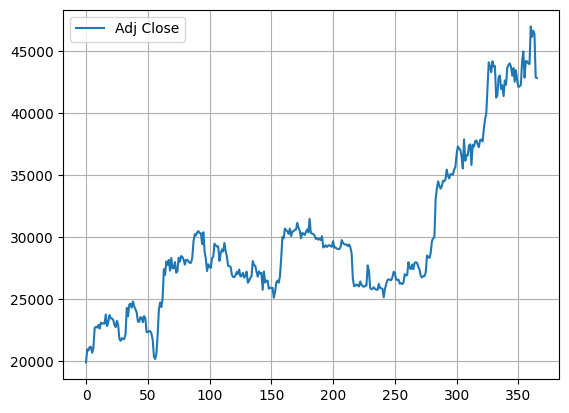

In [15]:
dataset[['Adj Close']].plot(grid=True)
plt.show()

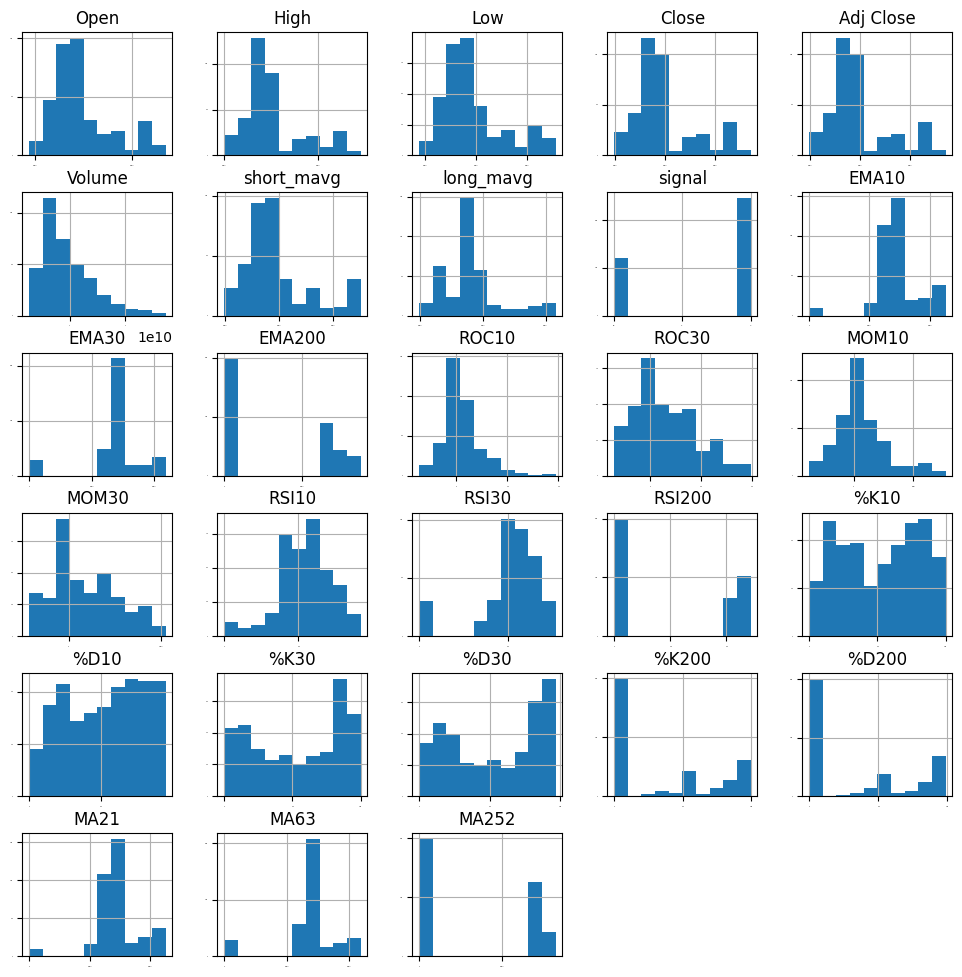

In [16]:
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

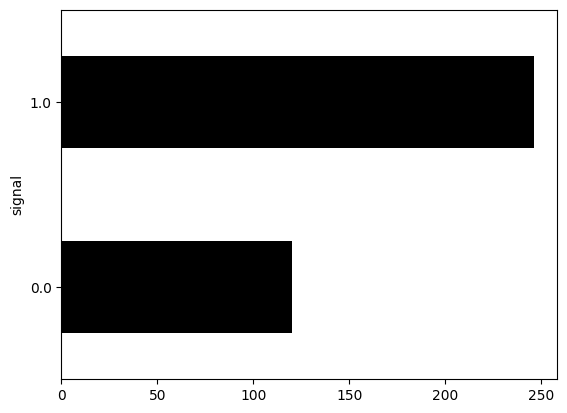

In [17]:
fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='black')
plt.show()

<ipython-input-18-71a722e68ac2>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = dataset.corr()


<Axes: title={'center': 'Correlation Matrix'}>

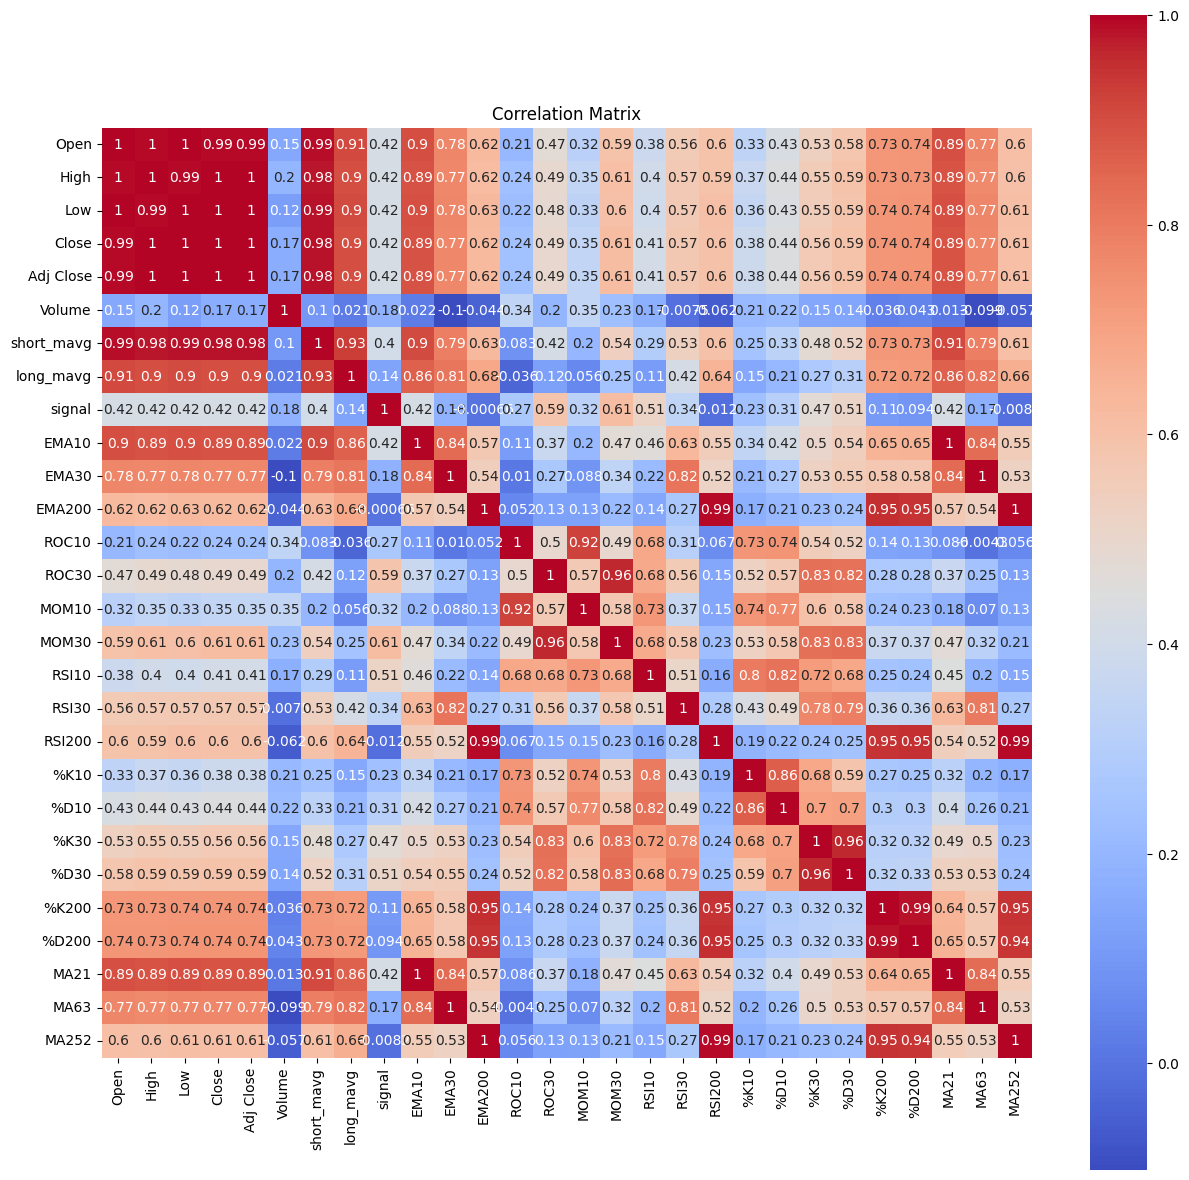

In [18]:
# correlation
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='coolwarm')

In [19]:
dataset=dataset.drop(['High','Low','Open', 'Volume','short_mavg','long_mavg'], axis=1)

In [20]:
dataset.sample(5)

,Date,Close,Adj Close,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
9,2023-01-22,22720.416016,22720.416016,0.0,21861.683838,0.000000,0.000000,14.118041,0.000000,0.000000,...,0.000000,87.593092,0.000000,0.000000,0.000000,0.000000,0.000000,21404.799219,0.000000,0.000000
213,2023-08-14,29408.443359,29408.443359,0.0,29374.438463,29449.536214,28105.328863,1.261328,-2.779218,334.351562,...,55.378618,47.106997,44.399134,42.201868,34.432775,80.255863,79.933073,29352.617578,29482.693359,27202.523750
52,2023-03-06,22429.757813,22429.757813,1.0,22919.907641,23144.424650,0.000000,-3.217282,-2.290973,-768.369140,...,0.000000,13.723249,10.882139,26.392547,25.751540,0.000000,0.000000,23011.013086,23175.120182,0.000000
74,2023-03-28,27268.130859,27268.130859,1.0,27174.787859,25550.432623,0.000000,-2.748150,15.921780,302.251953,...,0.000000,30.111418,44.453864,83.267669,85.440064,0.000000,0.000000,27701.348047,24681.122135,0.000000
226,2023-08-27,26089.693359,26089.693359,0.0,26467.643757,27705.917728,27896.878666,0.154078,-11.129318,-574.857422,...,53.165315,44.192584,26.300560,14.274893,13.413149,53.022326,52.685182,26123.098047,28141.221159,27422.561631


# Model Train Testing


In [66]:
# split out validation dataset for the end
subset_dataset= dataset.iloc[-100000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
seed = 0
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

In [67]:
# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'

In [68]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

#Neural Network
models.append(('NN', MLPClassifier()))

# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

In [69]:
print(X_train.shape, Y_train.shape)

(292, 22) (292,)


In [70]:
len_X_train = len(X_train)
len_y_train = len(Y_train)
print(len_X_train, len_y_train)

292 292


In [78]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
import pandas as pd

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train = imputer.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_train = X_train.dropna()
results = []
names = []
for name, model in models:
  kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

LR: 0.893908 (0.041811)
LDA: 0.948506 (0.044210)
KNN: 0.928161 (0.052005)
CART: 0.924483 (0.050809)
NB: 0.760690 (0.081343)
NN: 0.770920 (0.128170)
AB: 0.976092 (0.026555)
GBM: 0.979425 (0.022806)
RF: 0.952299 (0.048780)


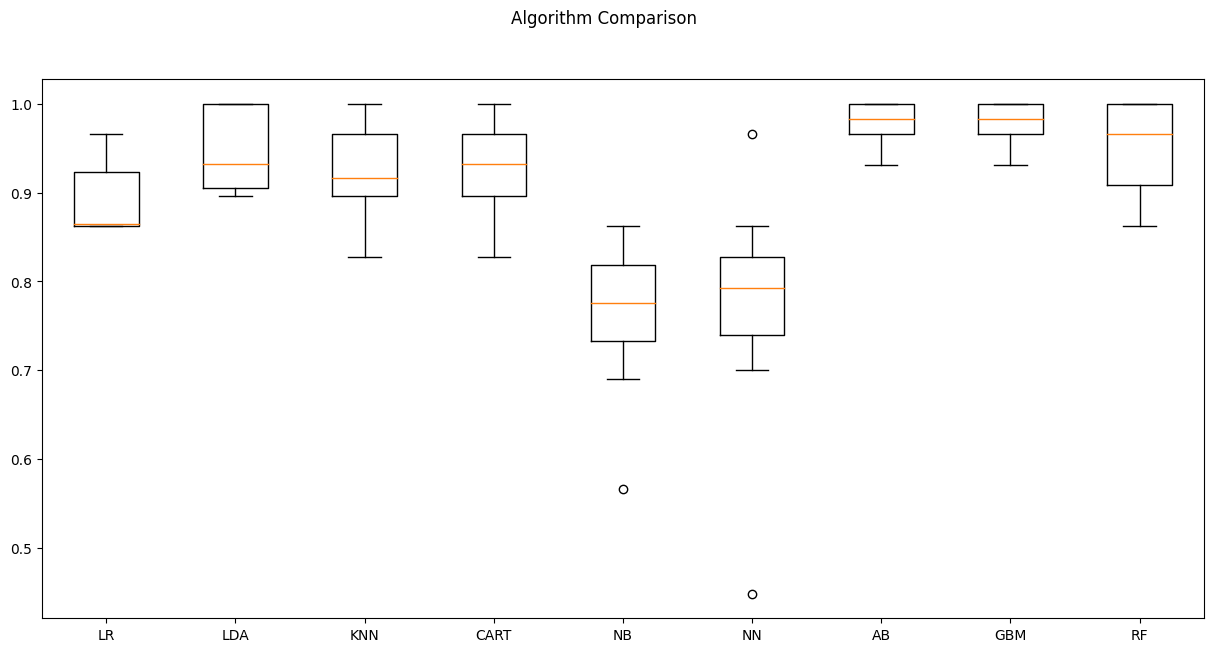

In [79]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,7)
plt.show()

# Model Tuning

In [80]:
# Random Forest Classifier
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"] #for disition tree
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.951839 using {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#2 0.948506 (0.038658) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#6 0.944943 (0.046827) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#4 0.948391 (0.035392) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#1 0.951839 (0.044197) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#8 0.938161 (0.037312) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#2 0.948506 (0.038658) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#5 0.945057 (0.038322) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#6 0.944943 (0.049301) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


# Performance Model

In [81]:
# prepare model
model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=10,n_jobs=-1)    # number of tree before maximaum or average prediction
#model = LogisticRegression()

model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=80, n_jobs=-1)

In [ ]:
# Check for missing values
print(X_validation.isnull().sum())


In [102]:
print(X_validation.dtypes)

Date         datetime64[ns]
Close               float64
Adj Close           float64
EMA10               float64
EMA30               float64
EMA200              float64
ROC10               float64
ROC30               float64
MOM10               float64
MOM30               float64
RSI10               float64
RSI30               float64
RSI200              float64
%K10                float64
%D10                float64
%K30                float64
%D30                float64
%K200               float64
%D200               float64
MA21                float64
MA63                float64
MA252               float64
dtype: object


In [150]:
# estimate accuracy on validation set
X_validation = np.delete(X_validation, 21, axis=1)
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.7972972972972973
[[24  2]
 [13 35]]
              precision    recall  f1-score   support

         0.0       0.65      0.92      0.76        26
         1.0       0.95      0.73      0.82        48

    accuracy                           0.80        74
   macro avg       0.80      0.83      0.79        74
weighted avg       0.84      0.80      0.80        74



<Axes: xlabel='Predicted', ylabel='Actual'>

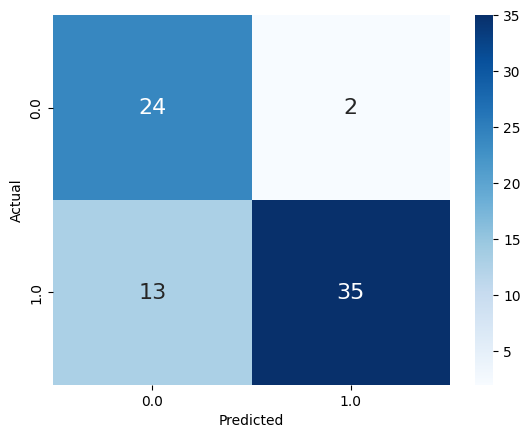

In [151]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

Text(0.5, 0, 'Variable Importance')

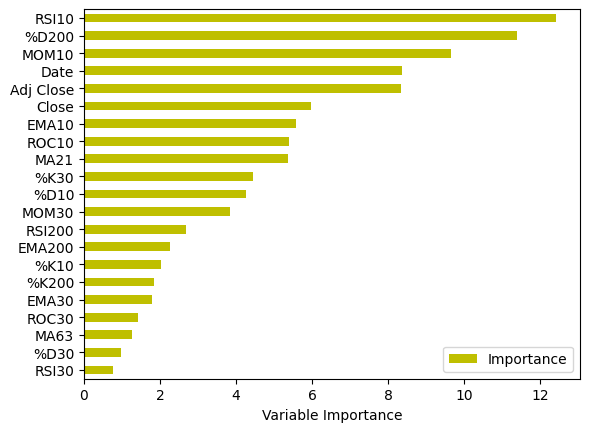

In [157]:
Importance = pd.DataFrame({'Importance': model.feature_importances_*100}, index=X.columns[:-1])
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='y' )
plt.xlabel('Variable Importance')